# Optimize a dense network with Bayesian optimization
Authors: Javier Duarte, Thong Nguyen

## Loading `pandas` DataFrames
Now we load two different `NumPy` arrays. One corresponding to the VV signal and one corresponding to the background.

In [1]:
import uproot
import numpy as np
import pandas as pd
import h5py

# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

treename = "HZZ4LeptonsAnalysisReduced"
filename = {}
upfile = {}
params = {}
df = {}

filename["VV"] = "data/ntuple_4mu_VV.root"
filename["bkg"] = "data/ntuple_4mu_bkg.root"

VARS = ["f_mass4l", "f_massjj"]  # choose which vars to use (2d)

upfile["VV"] = uproot.open(filename["VV"])
upfile["bkg"] = uproot.open(filename["bkg"])

df["bkg"] = upfile["bkg"][treename].arrays(VARS, library="pd")
df["VV"] = upfile["VV"][treename].arrays(VARS, library="pd")

# cut out undefined variables VARS[0] and VARS[1] > -999
df["VV"] = df["VV"][(df["VV"][VARS[0]] > -999) & (df["VV"][VARS[1]] > -999)]
df["bkg"] = df["bkg"][(df["bkg"][VARS[0]] > -999) & (df["bkg"][VARS[1]] > -999)]

# add isSignal variable
df["VV"]["isSignal"] = np.ones(len(df["VV"]))
df["bkg"]["isSignal"] = np.zeros(len(df["bkg"]))

## Define the model
We'll start with a dense (fully-connected) NN layer.
Our model will have a single fully-connected hidden layer with the same number of neurons as input variables. 
The weights are initialized using a small Gaussian random number. 
We will switch between linear and tanh activation functions for the hidden layer.
The output layer contains a single neuron in order to make predictions. 
It uses the sigmoid activation function in order to produce a probability output in the range of 0 to 1.

We are using the `binary_crossentropy` loss function during training, a standard loss function for binary classification problems. 
We will optimize the model with the Adam algorithm for stochastic gradient descent and we will collect accuracy metrics while the model is trained.

In [3]:
# baseline keras model
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import (
    Input,
    Activation,
    Dense,
    Convolution2D,
    MaxPooling2D,
    Dropout,
    Flatten,
)
from tensorflow.keras import optimizers

NDIM = len(VARS)
inputs = Input(shape=(NDIM,), name="input")
outputs = Dense(1, name="output", kernel_initializer="normal", activation="sigmoid")(inputs)

# creae the model
model = Model(inputs=inputs, outputs=outputs)
# compile the model
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
# print the model summary
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 2)]               0         
_________________________________________________________________
output (Dense)               (None, 1)                 3         
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________


2022-07-11 21:53:58.557604: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Dividing the data into testing and training dataset

We will split the data into two parts (one for training+validation and one for testing). 
We will also apply "standard scaling" preprocessing: http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html i.e. making the mean = 0 and the RMS = 1 for all input variables (based **only** on the training/validation dataset).
We will also define our early stopping criteria to prevent over-fitting and we will save the model based on the best `val_loss`.

In [5]:
df_all = pd.concat([df["VV"], df["bkg"]])
dataset = df_all.values
X = dataset[:, 0:NDIM]
Y = dataset[:, NDIM]

from sklearn.model_selection import train_test_split

X_train_val, X_test, Y_train_val, Y_test = train_test_split(X, Y, test_size=0.2, random_state=7)

# preprocessing: standard scalar
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(X_train_val)
X_train_val = scaler.transform(X_train_val)
X_test = scaler.transform(X_test)

# early stopping callback
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor="val_loss", patience=10)

# model checkpoint callback
# this saves our model architecture + parameters into dense_model.h5
from tensorflow.keras.callbacks import ModelCheckpoint

model_checkpoint = ModelCheckpoint(
    "dense_model.h5",
    monitor="val_loss",
    verbose=0,
    save_best_only=True,
    save_weights_only=False,
    mode="auto",
    period=1,
)

## Run training 
Here, we run the training.

In [6]:
# Train classifier
import time

begt = time.time()
history = model.fit(
    X_train_val,
    Y_train_val,
    epochs=100,
    batch_size=1024,
    verbose=0,  # switch to 1 for more verbosity
    callbacks=[early_stopping, model_checkpoint],
    validation_split=0.25,
)
print("Finished in {}s".format(time.time() - begt))

2022-07-11 21:54:07.493636: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-07-11 21:54:07.494348: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2099920000 Hz


Finished in 4.753435134887695s


## Optimize the hyperparameters of the model
The hyperperparameters of the model that we weill optimize are the number of hidden layers `num_hidden`, the number of nodes in each layer `initial_node`, and the fraction of dropout `dropout`.

In [7]:
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args


def build_custom_model(num_hiddens=2, initial_node=50, dropout=0.5):
    inputs = Input(shape=(NDIM,), name="input")
    hidden = None
    for i in range(num_hiddens):
        hidden = Dense(int(round(initial_node / np.power(2, i))), activation="relu")(
            inputs if i == 0 else hidden
        )
        hidden = Dropout(np.float32(dropout))(hidden)
    outputs = Dense(1, name="output", kernel_initializer="normal", activation="sigmoid")(hidden)
    model = Model(inputs=inputs, outputs=outputs)

    return model


def train(batch_size=1000):
    history = model.fit(
        X_train_val,
        Y_train_val,
        epochs=100,
        batch_size=batch_size,
        verbose=0,  # switch to 1 for more verbosity
        callbacks=[early_stopping, model_checkpoint],
        validation_split=0.25,
    )
    best_acc = max(history.history["val_accuracy"])
    return best_acc


space = [
    Integer(1, 3, name="hidden_layers"),
    Integer(5, 100, name="initial_nodes"),
    Real(0.0, 0.9, name="dropout"),
    Integer(500, 5000, name="batch_size"),
    Real(10**-5, 10**-1, "log-uniform", name="learning_rate"),
]


@use_named_args(space)
def objective(**X):
    print("New configuration: {}".format(X))

    model = build_custom_model(
        num_hiddens=X["hidden_layers"], initial_node=X["initial_nodes"], dropout=X["dropout"]
    )

    model.compile(
        optimizer=optimizers.Adam(lr=X["learning_rate"]),
        loss="binary_crossentropy",
        metrics=["accuracy"],
    )
    model.summary()

    best_acc = train(batch_size=X["batch_size"])

    print("Best acc: {}".format(best_acc))
    return -best_acc


begt = time.time()
res_gp = gp_minimize(objective, space, n_calls=20, random_state=3)
print("Finish optimization in {}s".format(time.time() - begt))

New configuration: {'hidden_layers': 1, 'initial_nodes': 85, 'dropout': 0.10919572308469448, 'batch_size': 3062, 'learning_rate': 0.0005600770399424082}
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 2)]               0         
_________________________________________________________________
dense (Dense)                (None, 85)                255       
_________________________________________________________________
dropout (Dropout)            (None, 85)                0         
_________________________________________________________________
output (Dense)               (None, 1)                 86        
Total params: 341
Trainable params: 341
Non-trainable params: 0
_________________________________________________________________


/home/cms.rkansal/miniconda3/envs/machine-learning-hats-2022/lib/python3.9/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Best acc: 0.9269527196884155
New configuration: {'hidden_layers': 1, 'initial_nodes': 9, 'dropout': 0.22309946750343207, 'batch_size': 921, 'learning_rate': 0.006015816920825813}
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 2)]               0         
_________________________________________________________________
dense_1 (Dense)              (None, 9)                 27        
_________________________________________________________________
dropout_1 (Dropout)          (None, 9)                 0         
_________________________________________________________________
output (Dense)               (None, 1)                 10        
Total params: 37
Trainable params: 37
Non-trainable params: 0
_________________________________________________________________
Best acc: 0.9390067458152771
New configuration: {'hidden_layers': 1, 'initial_node

Best acc: 0.9505785703659058
New configuration: {'hidden_layers': 2, 'initial_nodes': 76, 'dropout': 0.5486612987713032, 'batch_size': 1415, 'learning_rate': 0.004116455326627872}
Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 2)]               0         
_________________________________________________________________
dense_14 (Dense)             (None, 76)                228       
_________________________________________________________________
dropout_14 (Dropout)         (None, 76)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 38)                2926      
_________________________________________________________________
dropout_15 (Dropout)         (None, 38)                0         
_________________________________________________________________
output (Den

/home/cms.rkansal/miniconda3/envs/machine-learning-hats-2022/lib/python3.9/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Best acc: 0.9513018131256104
New configuration: {'hidden_layers': 1, 'initial_nodes': 44, 'dropout': 0.46309479901862954, 'batch_size': 556, 'learning_rate': 0.0798827198804181}
Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 2)]               0         
_________________________________________________________________
dense_21 (Dense)             (None, 44)                132       
_________________________________________________________________
dropout_21 (Dropout)         (None, 44)                0         
_________________________________________________________________
output (Dense)               (None, 1)                 45        
Total params: 177
Trainable params: 177
Non-trainable params: 0
_________________________________________________________________


/home/cms.rkansal/miniconda3/envs/machine-learning-hats-2022/lib/python3.9/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Best acc: 0.9515429139137268
New configuration: {'hidden_layers': 3, 'initial_nodes': 100, 'dropout': 0.4067987179973009, 'batch_size': 5000, 'learning_rate': 0.1}
Model: "model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 2)]               0         
_________________________________________________________________
dense_22 (Dense)             (None, 100)               300       
_________________________________________________________________
dropout_22 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 50)                5050      
_________________________________________________________________
dropout_23 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_24 (Dense)          

/home/cms.rkansal/miniconda3/envs/machine-learning-hats-2022/lib/python3.9/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Best acc: 0.9515429139137268
New configuration: {'hidden_layers': 3, 'initial_nodes': 100, 'dropout': 0.4982381104731523, 'batch_size': 5000, 'learning_rate': 1e-05}
Model: "model_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 2)]               0         
_________________________________________________________________
dense_25 (Dense)             (None, 100)               300       
_________________________________________________________________
dropout_25 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 50)                5050      
_________________________________________________________________
dropout_26 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_27 (Dense)        

/home/cms.rkansal/miniconda3/envs/machine-learning-hats-2022/lib/python3.9/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Best acc: 0.9515429139137268
New configuration: {'hidden_layers': 1, 'initial_nodes': 14, 'dropout': 0.34733425561414655, 'batch_size': 601, 'learning_rate': 0.00017779328843182263}
Model: "model_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 2)]               0         
_________________________________________________________________
dense_28 (Dense)             (None, 14)                42        
_________________________________________________________________
dropout_28 (Dropout)         (None, 14)                0         
_________________________________________________________________
output (Dense)               (None, 1)                 15        
Total params: 57
Trainable params: 57
Non-trainable params: 0
_________________________________________________________________


/home/cms.rkansal/miniconda3/envs/machine-learning-hats-2022/lib/python3.9/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Best acc: 0.9517840147018433
New configuration: {'hidden_layers': 3, 'initial_nodes': 63, 'dropout': 5.503648636758786e-05, 'batch_size': 2413, 'learning_rate': 2.260306625151787e-05}
Model: "model_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 2)]               0         
_________________________________________________________________
dense_29 (Dense)             (None, 63)                189       
_________________________________________________________________
dropout_29 (Dropout)         (None, 63)                0         
_________________________________________________________________
dense_30 (Dense)             (None, 32)                2048      
_________________________________________________________________
dropout_30 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_

/home/cms.rkansal/miniconda3/envs/machine-learning-hats-2022/lib/python3.9/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Best acc: 0.9517840147018433
New configuration: {'hidden_layers': 1, 'initial_nodes': 93, 'dropout': 0.9, 'batch_size': 4594, 'learning_rate': 0.07356215620398546}
Model: "model_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 2)]               0         
_________________________________________________________________
dense_32 (Dense)             (None, 93)                279       
_________________________________________________________________
dropout_32 (Dropout)         (None, 93)                0         
_________________________________________________________________
output (Dense)               (None, 1)                 94        
Total params: 373
Trainable params: 373
Non-trainable params: 0
_________________________________________________________________


/home/cms.rkansal/miniconda3/envs/machine-learning-hats-2022/lib/python3.9/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Best acc: 0.9517840147018433
New configuration: {'hidden_layers': 3, 'initial_nodes': 23, 'dropout': 0.18499533850346483, 'batch_size': 4459, 'learning_rate': 0.0005377686889554435}
Model: "model_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 2)]               0         
_________________________________________________________________
dense_33 (Dense)             (None, 23)                69        
_________________________________________________________________
dropout_33 (Dropout)         (None, 23)                0         
_________________________________________________________________
dense_34 (Dense)             (None, 12)                288       
_________________________________________________________________
dropout_34 (Dropout)         (None, 12)                0         
_________________________________________________________________
dense_35

/home/cms.rkansal/miniconda3/envs/machine-learning-hats-2022/lib/python3.9/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Best acc: 0.9515429139137268
New configuration: {'hidden_layers': 2, 'initial_nodes': 22, 'dropout': 0.8998211088920843, 'batch_size': 639, 'learning_rate': 0.007478381525904193}
Model: "model_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 2)]               0         
_________________________________________________________________
dense_36 (Dense)             (None, 22)                66        
_________________________________________________________________
dropout_36 (Dropout)         (None, 22)                0         
_________________________________________________________________
dense_37 (Dense)             (None, 11)                253       
_________________________________________________________________
dropout_37 (Dropout)         (None, 11)                0         
_________________________________________________________________
output (Den

/home/cms.rkansal/miniconda3/envs/machine-learning-hats-2022/lib/python3.9/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Best acc: 0.9517840147018433
New configuration: {'hidden_layers': 2, 'initial_nodes': 26, 'dropout': 0.42163653305477045, 'batch_size': 4824, 'learning_rate': 1.4616042209619643e-05}
Model: "model_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 2)]               0         
_________________________________________________________________
dense_38 (Dense)             (None, 26)                78        
_________________________________________________________________
dropout_38 (Dropout)         (None, 26)                0         
_________________________________________________________________
dense_39 (Dense)             (None, 13)                351       
_________________________________________________________________
dropout_39 (Dropout)         (None, 13)                0         
_________________________________________________________________
output 

/home/cms.rkansal/miniconda3/envs/machine-learning-hats-2022/lib/python3.9/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Best acc: 0.9517840147018433
Finish optimization in 53.88740849494934s


## Visualize the improvement
Let's see how Bayesian optimization improves the accuracy

<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

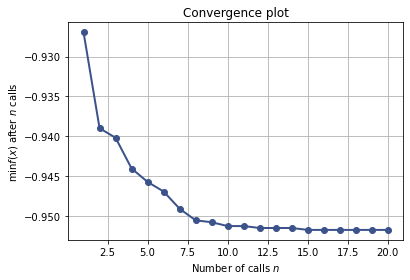

In [8]:
from skopt.plots import plot_convergence

plot_convergence(res_gp)

In [9]:
print(
    "Best parameters: \
\nbest_hidden_layers = {} \
\nbest_initial_nodes = {} \
\nbest_dropout = {} \
\nbest_batch_size = {} \
\nbest_learning_rate = {}".format(
        res_gp.x[0], res_gp.x[1], res_gp.x[2], res_gp.x[3], res_gp.x[4]
    )
)

Best parameters: 
best_hidden_layers = 1 
best_initial_nodes = 14 
best_dropout = 0.34733425561414655 
best_batch_size = 601 
best_learning_rate = 0.00017779328843182263


## Plot performance
Here, we plot the history of the training and the performance in a ROC curve

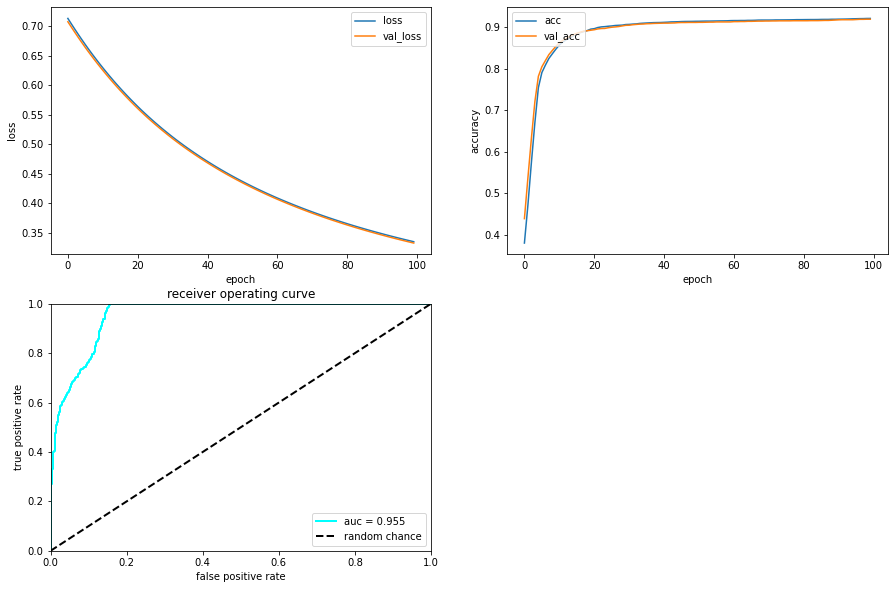

In [10]:
import matplotlib.pyplot as plt

%matplotlib inline
# plot loss vs epoch
plt.figure(figsize=(15, 10))
ax = plt.subplot(2, 2, 1)
ax.plot(history.history["loss"], label="loss")
ax.plot(history.history["val_loss"], label="val_loss")
ax.legend(loc="upper right")
ax.set_xlabel("epoch")
ax.set_ylabel("loss")

# plot accuracy vs epoch
ax = plt.subplot(2, 2, 2)
ax.plot(history.history["accuracy"], label="acc")
ax.plot(history.history["val_accuracy"], label="val_acc")
ax.legend(loc="upper left")
ax.set_xlabel("epoch")
ax.set_ylabel("accuracy")

# Plot ROC
Y_predict = model.predict(X_test)
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(Y_test, Y_predict)
roc_auc = auc(fpr, tpr)
ax = plt.subplot(2, 2, 3)
ax.plot(fpr, tpr, lw=2, color="cyan", label="auc = %.3f" % (roc_auc))
ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="k", label="random chance")
ax.set_xlim([0, 1.0])
ax.set_ylim([0, 1.0])
ax.set_xlabel("false positive rate")
ax.set_ylabel("true positive rate")
ax.set_title("receiver operating curve")
ax.legend(loc="lower right")
plt.show()